In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx

In this notebook, you'll determine the relation between mixing time and the number of nodes in a graph. 

## networkx

The first task to get some familiarity with `networkx`. For all of the tasks below, use the `networkx` library.

1. Create a cycle graph with 15 vertices.
2. Draw the graph.
3. Print its number of nodes, number of edges, the adjacency matrix.
4. Plot the eigenvalues of the normalized Laplacian matrix in increasing order. You'll need to use `todense()` to convert the sparse matrix produced by `networkx.normalized_laplacian_matrix()` to a dense matrix.

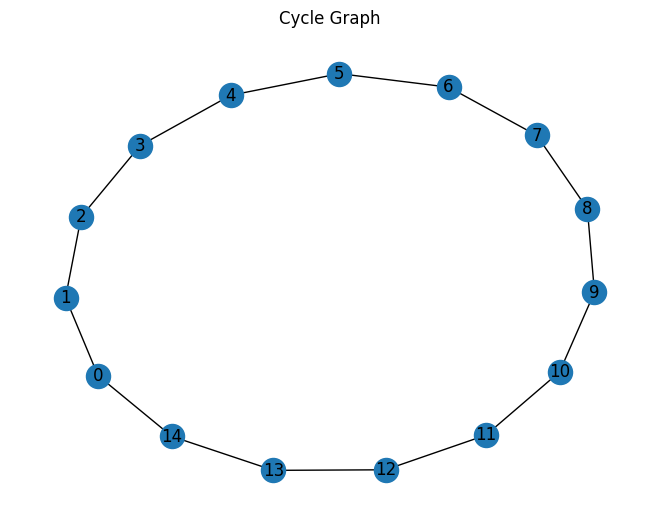

Number of nodes = 15
Number of edges = 15
Adjacency matrix = 
 [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


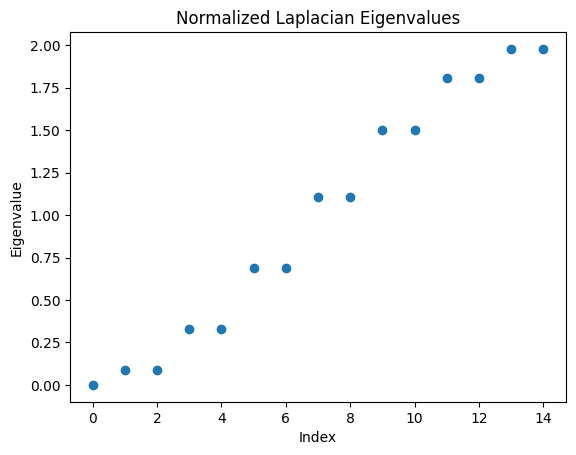

In [16]:
# Test the networkx library
G: nx.Graph = nx.cycle_graph(15)
nx.draw(G, with_labels=True)
plt.title('Cycle Graph')
plt.show()
print("Number of nodes =", len(G.nodes))
print("Number of edges =", len(G.edges))
print("Adjacency matrix = \n", nx.adjacency_matrix(G).todense())
lap_adj_matrix = nx.normalized_laplacian_matrix(G).todense()
eigvals = sorted(np.linalg.eigvals(lap_adj_matrix))
plt.plot(eigvals, 'o')
plt.title('Normalized Laplacian Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()


## GraphMC 

Define the following methods for the class `GraphMC`. Instead of finding the `mixing_time` over all possible distributions, we'll simply find the mixing time from a given initial distribution.

In [17]:
class GraphMC(nx.Graph):
    def __init__(self, graph):
        super().__init__(graph)  # Initialize from an existing graph
        self.trans_matrix = nx.adjacency_matrix(self).todense() / np.sum(nx.adjacency_matrix(self), axis=1)
    
    def transition_probabilities(self, start_node, end_node):
        assert start_node in self.nodes, "Start node must be in the graph"
        assert end_node in self.nodes, "End node must be in the graph"
        return self.trans_matrix[start_node, end_node]

    def stationary_distribution(self):
        eigvals, eigvecs = np.linalg.eig(self.trans_matrix.T)
        idx = np.argmin(np.abs(eigvals - 1.0))
        stat_dist = np.abs(eigvecs[:, idx])
        return stat_dist / np.sum(stat_dist)

    def update(self, distribution, num_steps=1):
        assert len(distribution) == len(self.nodes), "Distribution length must match number of nodes"
        return distribution @ np.linalg.matrix_power(self.trans_matrix, num_steps)

    def total_variational_distance(self, distribution):
        assert len(distribution) == len(self.nodes), "Distribution length must match number of nodes"
        stationary_dist = self.stationary_distribution()
        return 0.5 * np.sum(np.abs(stationary_dist - distribution))
        
    def mixing_time(self, starting_distribution, epsilon=0.25, max_steps=1000):
        assert len(starting_distribution) == len(self.nodes), "Distribution length must match number of nodes"
        steps = 0
        x = starting_distribution.copy()
        while self.total_variational_distance(x) > epsilon and steps <= max_steps:
            x = self.update(x)
            steps += 1
        return steps


## Test 1

Test your class on a cycle graph with 15 vertices. Start with the distribution where all the probability is concentrated on a single node.

1. Run the markov chain for 100 steps and compute the total variation distance between the distribution and the stationary distribution.
2. Plot the total variation distance as a function of the number of steps.
3. Mark the threshold $\epsilon = 0.25$ on the plot.
4. Print the mixing time.

Final TVD = 0.0700
Mixing time = 43


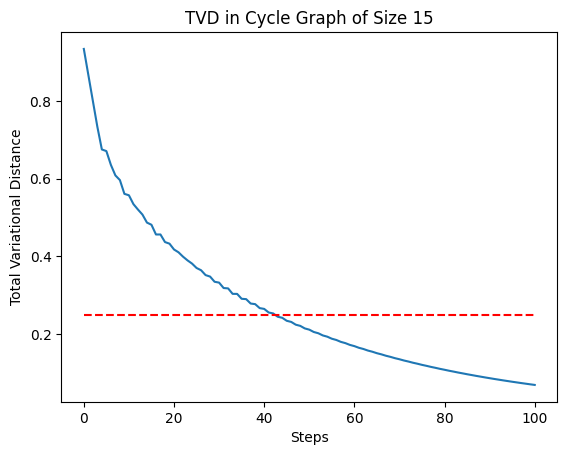

In [18]:
# Test 1
G: nx.Graph = nx.cycle_graph(15)
mc = GraphMC(G)
eps = 0.25
num_steps = 100

x = np.zeros(len(G.nodes))
x[0] = 1
dist = [None] * (num_steps + 1)
dist[0] = x

for i in range(0, num_steps):
    dist[i+1] = mc.update(dist[i], 1)
var_dist = [mc.total_variational_distance(d) for d in dist]

print(f"Final TVD = {var_dist[-1]:.4f}")
print("Mixing time =", mc.mixing_time(x, epsilon=eps))

plt.plot(var_dist)
plt.title('TVD in Cycle Graph of Size 15')
plt.xlabel('Steps')
plt.ylabel('Total Variational Distance')
plt.plot([eps] * len(var_dist), 'r--')
plt.show()

## Test 2

Test your class on a cycle graph with 16 vertices. Start with the distribution where all the probability is concentrated on a single node.

1. Run the markov chain for 100 steps and compute the total variation distance between the distribution and the stationary distribution.
2. Plot the total variation distance as a function of the number of steps.
3. Mark the threshold $\epsilon = 0.25$ on the plot.

What do you observe? Why is this case different from the previous one?

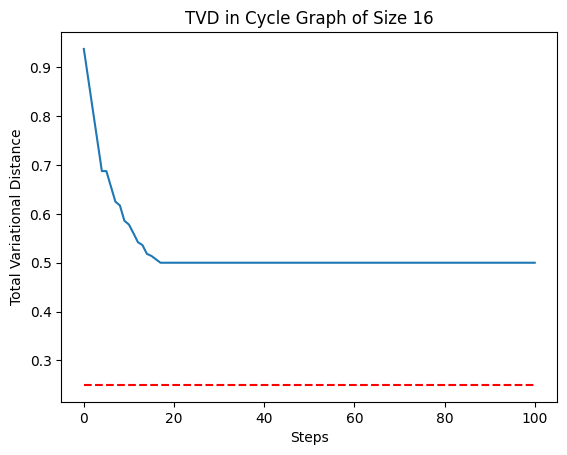

In [19]:
# Test 2
G: nx.Graph = nx.cycle_graph(16)
mc = GraphMC(G)
eps = 0.25
num_steps = 100

x = np.zeros(len(G.nodes))
x[0] = 1
dist = [None] * (num_steps + 1)
dist[0] = x

for i in range(0, num_steps):
    dist[i+1] = mc.update(dist[i], 1)
var_dist = [mc.total_variational_distance(d) for d in dist]

plt.plot(var_dist)
plt.title('TVD in Cycle Graph of Size 16')
plt.xlabel('Steps')
plt.ylabel('Total Variational Distance')
plt.plot([eps] * len(var_dist), 'r--')
plt.show()

While the previous graph has a $TVD$ that keeps decreasing to approach $0$, here the $TVD$ levels off at $0.5$. Even-sized cycle graphs like this one are bipartite, meaning that any random walk will always alternate between "red-colored" and "blue-colored" nodes. As the number of steps approaches infinity, the Markov chain's probability distribution approaches an oscillation between uniform across even-indexed nodes, and uniform across odd-indexed nodes. Since these distributions have an absolute fractional error of $1$ at each node and the sum of a distribution is $1$, the $TVD$ approaches $0.5$.

## Mixing time as a function of cycle length and spectral gap

Now vary the length of the cycle graph over odd numbers from 3 to 51.

1. Compute the mixing time for each cycle graph with the initial distribution where all the probability is concentrated on a single node.
2. Compute the spectral gap for each cycle graph. The spectral gap is the second smallest eigenvalue of the normalized Laplacian matrix.
3. Plot the mixing time vs the cycle length on a log-log scale. Find the rate of growth of the mixing time as a function of the number of nodes i.e. find $\alpha$ in the relation $mixing\_time = O(n^\alpha)$.
4. Plot the mixing time vs the spectral gap on a log-log scale. Find the rate of growth of the mixing time as a function of the spectral gap i.e. find $\beta$ in the relation $mixing\_time = O(gap^\beta)$.

Mixing time order: O(n^1.97), a = 1.97
Spectral gap order: O(n^-1.92), b = -1.92


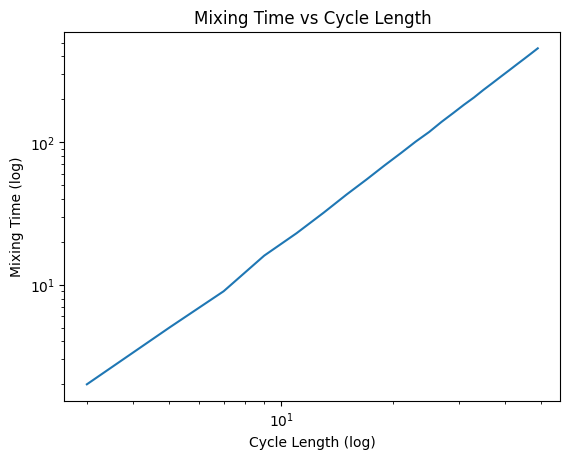

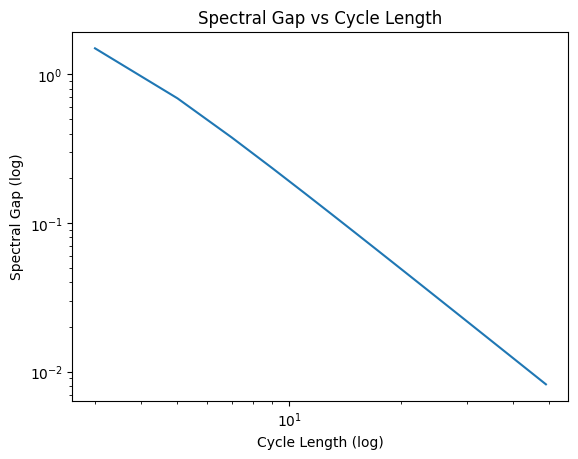

In [20]:
# Mixing time as a function of cycle length and spectral gap
num_nodes = np.arange(3, 51, 2)
mixing_time = np.zeros(len(num_nodes))
spectral_gap = np.zeros(len(num_nodes))

for i, n in enumerate(num_nodes):
    G: nx.Graph = nx.cycle_graph(n)
    mc = GraphMC(G)
    x = np.zeros(len(G.nodes))
    x[0] = 1
    mixing_time[i] = mc.mixing_time(x, epsilon=0.25)
    norm_lap = nx.normalized_laplacian_matrix(G).todense()
    eigvals = sorted(np.abs(np.linalg.eigvals(norm_lap)))
    spectral_gap[i] = eigvals[1]

reg_mixing_time = np.polyfit(np.log(num_nodes), np.log(mixing_time), 1)
reg_spectral_gap = np.polyfit(np.log(num_nodes), np.log(spectral_gap), 1)

a, b = reg_mixing_time[0], reg_spectral_gap[0]
print(f"Mixing time order: O(n^{a:.2f}), a = {a:.2f}")
print(f"Spectral gap order: O(n^{b:.2f}), b = {b:.2f}")

plt.plot(num_nodes, mixing_time)
plt.xscale('log')
plt.yscale('log')
plt.title('Mixing Time vs Cycle Length')
plt.xlabel('Cycle Length (log)')
plt.ylabel('Mixing Time (log)')
plt.show()

plt.plot(num_nodes, spectral_gap)
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Gap vs Cycle Length')
plt.xlabel('Cycle Length (log)')
plt.ylabel('Spectral Gap (log)')
plt.show()